In [1]:
from example import spark

:: loading settings :: url = jar:file:/Users/da/.pyenv/versions/3.8.10/envs/rikai-example/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/da/.ivy2/cache
The jars for the packages stored in: /Users/da/.ivy2/jars
ai.eto#rikai_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5700bfa3-bdd9-4981-b95d-ab7d8318726b;1.0
	confs: [default]
	found ai.eto#rikai_2.12;0.0.12 in central
	found org.antlr#antlr4-runtime;4.8-1 in local-m2-cache
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found org.apache.logging.log4j#log4j-api-scala_2.12;12.0 in central
	found org.scala-lang#scala-reflect;2.12.10 in spark-list
	found org.apache.logging.log4j#log4j-api;2.13.2 in central
	found io.circe#circe-core_2.12;0.12.3 in central
	found io.circe#circe-numbers_2.12;0.12.3 in central
	found org.typelevel#cats-core_2.12;2.0.0 in central
	found org.typelevel#cats-macros_2.12;2.0.0 in central
	found org.typelevel#cats-kernel_2.12;2.0.0 in central
	found io.circe#circe-generic_2.12;0.12.3 in central
	found com.chuusai#shapeless_2.12;2.3.3 in spark-list
	found org.typ

In [2]:
df = spark.read.format("parquet").load("/tmp/rikai_example/elephants_dream")
df.createOrReplaceTempView("elephants_dream")

In [3]:
mlflow_tracking_uri = "sqlite:///mlruns.db"
registered_model_name = f"yolov5s-model"

spark.conf.set("rikai.sql.ml.registry.mlflow.tracking_uri", mlflow_tracking_uri)

spark.sql(f"""
    CREATE OR REPLACE MODEL mlflow_yolov5_m
    PREPROCESSOR 'rikai.contrib.torch.transforms.yolov5.pre_processing'
    POSTPROCESSOR 'rikai.contrib.torch.transforms.yolov5.post_processing'
    USING 'mlflow:///{registered_model_name}';
""")


2021-10-21 17:05:36,405 INFO Rikai (mlflow_registry.py:223): Resolving model mlflow_yolov5_m from mlflow:///yolov5s-model
2021-10-21 17:05:37,188 INFO Rikai (base.py:207): Created model inference pandas_udf with name mlflow_yolov5_m_c561bc76


DataFrame[]

In [8]:
# Inspect Bounding Boxes on an Image
from rikai.types.vision import Image
from rikai.spark.types.vision import ImageType
from rikai.types.geometry import Box2d
from pyspark.sql.functions import udf
from PIL import ImageDraw

@udf(returnType=ImageType())
def inspect_bounding_boxes(img: Image, boxes, labels):
    pil_image = img.to_pil()
    draw = ImageDraw.Draw(pil_image)
    for i in range(len(labels)):
        box = boxes[i]
        label = labels[i]
        bbox = Box2d(box[0], box[1], box[2], box[3])
        draw.rectangle(bbox.to_numpy().tolist(), outline="green", width=2)
        draw.text([bbox.xmin + 5, bbox.ymin - 10], str(label), fill="red")
    return Image.from_pil(pil_image)

spark.udf.register("inspect_bbox", inspect_bounding_boxes)

21/10/21 17:10:26 WARN SimpleFunctionRegistry: The function inspect_bbox replaced a previously registered function.


<function __main__.inspect_bounding_boxes(img: rikai.types.vision.Image, boxes, labels)>

In [9]:
import cv2
from rikai.types.vision import Image
from pyspark.sql.functions import udf
from rikai.spark.types.vision import ImageType


@udf(returnType=ImageType())
def frame(path: str, frame_id: int): 
    cap = cv2.VideoCapture(path)
    frame_cnt = 0
    img0 = None
    while frame_cnt <= frame_id:
        ret_val, img0 = cap.read()
        if not ret_val:
            print(f"{frame_id} out of bound")
            return
        frame_cnt = frame_cnt + 1
    cap.release()
    img = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    return Image.from_array(img)

spark.udf.register('frame', frame)

<function __main__.frame(path: str, frame_id: int)>

In [16]:
predicts = spark.sql("""
from (
    from (
        select
            frame_id,
            ML_PREDICT(mlflow_yolov5_m, image) as pred 
        from elephants_dream
    )
    select
        frame('elephants_dream.mp4', frame_id) as image,
        pred
    where
        size(pred.label_ids) > 0
)
select
    image,
    pred,
    inspect_bbox(image, pred.boxes, pred.label_ids) as bbox
""")

In [25]:
rows = predicts.limit(10).collect()

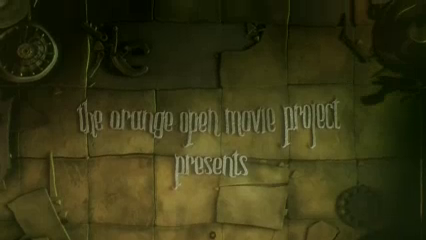

In [38]:
rows[0].image

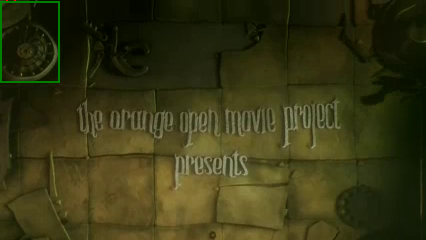

In [28]:
rows[0].bbox

In [39]:
rows[0].pred

Row(boxes=[[0.27957141399383545, 1.4062223434448242, 59.57040786743164, 82.97673797607422]], scores=[0.3434305787086487], label_ids=[74])

In [22]:
spark.sql("""
select * from parquet.`/tmp/rikai_example/coco_labels`
where id = 74
order by id asc
""").show()

+---+------+
| id| label|
+---+------+
| 74|remote|
+---+------+

